In [5]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import os
from cmapPy.pandasGEXpress.parse import parse
from utils.replicateCorrs import replicateCorrs
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from importlib import reload
# sns.set_style("whitegrid")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# np.__version__


###  Cell Painting morphological (CP) and L1000 gene expression (GE) profiles for the following datasets:
 
- **CDRPBIO**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ There are 30,430 unique compounds for CP dataset, median number of replicates --> 4
    * $\bf{GE}$ There are 21,782 unique compounds for GE dataset, median number of replicates --> 3
    * 20,358 compounds are present in both datasets.
    
    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ There are 593 unique alleles for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 529 unique alleles for GE dataset, median number of replicates --> 8
    * 525 alleles are present in both datasets.
    
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ There are 299 unique alleles for CP dataset, median number of replicates --> 8
    * $\bf{GE}$ There are 226 unique alleles for GE dataset, median number of replicates --> 3
    * 188 alleles are present in both datasets.
    
--------------------------------------------


###  Input / ouput files:
 
- **CDRPBIO**-BBBC047-Bray-CP-GE (Cell line: U2OS) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input: .mat files that are generated using https://github.com/broadinstitute/2014_wawer_pnas
        * Output:
    
- **LUAD**-BBBC041-Caicedo-CP-GE (Cell line: A549) : 
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:
        * Output:
    
- **TA-ORF**-BBBC037-Rohban-CP-GE (Cell line: U2OS) :
    * $\bf{CP}$ 
        * Input:
        * Output:
        
    * $\bf{GE}$ 
        * Input:  https://data.broadinstitute.org/icmap/custom/TA/brew/pc/TA.OE005_U2OS_72H/
        * Output:

In [6]:
fileName='RepCorrDF'
### dirs on gpu cluster
# rawProf_dir='/storage/data/marziehhaghighi/Rosetta/raw-profiles/'
# procProf_dir='/home/marziehhaghighi/workspace_rosetta/workspace/'

### dirs on ec2
rawProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/'
procProf_dir='./'


filename=procProf_dir+'results/RepCor/'+fileName+'.xlsx'
# writer = pd.ExcelWriter(procProf_dir+'results/RepCor/'+fileName+'.xlsx', engine='xlsxwriter')

# dfRank.to_excel(writer, index=False, sheet_name='Sheet_1')
# writer.save()
# dtFimpact=dtFimpact[cols]
# dtFimpact.to_excel(writer, index=False, sheet_name='Sheet_2')
# dtFimpact.sort_values(by='CC-Prot').to_excel(writer, index=False, sheet_name='Sorted_by_prot_ch')
# dtFimpact.sort_values(by='CC-notProt').to_excel(writer, index=False, sheet_name='Sorted_by_non_prot_ch')
# dtFimpact.sort_values(by='Mutant').to_excel(writer, index=False, sheet_name='Sorted_by_Mutant')
# resultRepCor.sort_values(by='Metadata_Sample').reset_index(drop=True).to_excel(writer, index=False, sheet_name='replicate_correlations')


In [8]:
ls .

0-preprocess_datasets.ipynb        3-CP-from-to-GE.ipynb  preprocessed_data/
1-GeneVsCPfeature-analysis.ipynb   LICENSE                README.md
2-linearAndDeepCCA-analysis.ipynb  Old+drafts/            utils/


In [52]:
ls ~/workspace_rosetta/workspace/

collated/  preprocessed_data/  results/   software_backup_2019Nov30/
metadata/  raw_profiles/       software/  temp_weights.h5


### Reformat L1000 Data:
- It is usually in .gctx format
- Usefull link to read this format: https://github.com/cmap/cmapPy/blob/master/tutorials/cmapPy_pandasGEXpress_tutorial.ipynb

#### L1000 - TA_ORF 
- TA.OE005_U2OS_72H_QNORM_n729x978.gctx  
- TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx  

In [2]:
# ls ../../raw_profiles/l1000_TA_ORF
# df1.loc[:,featColNames].T.corr()

mv /home/marziehhaghighi/workspace_rosetta/workspace/raw_profiles/* /storage/data/marziehhaghighi/Rosetta/raw-profiles/

In [3]:
# taorf_l1k_df
# gene_info[['pert_id','x_genesymbol_mutation','pert_iname']]

In [4]:
# gene_info.groupby(['x_genesymbol_mutation']).size().describe()
# gene_info.columns

In [5]:
taorf_datadir=rawProf_dir+'/l1000_TA_ORF/'
gene_info = pd.read_csv(taorf_datadir+"TA.OE005_U2OS_72H.map.txt", sep="\t", dtype=str)
# gene_info.columns
# TA.OE005_U2OS_72H_INF_n729x22268.gctx
# TA.OE005_U2OS_72H_QNORM_n729x978.gctx
# TA.OE005_U2OS_72H_ZSPCINF_n729x22268.gctx
# TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx
taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx")
# taorf_l1k0 = parse(taorf_datadir+"TA.OE005_U2OS_72H_QNORM_n729x978.gctx")
taorf_l1k_df0=taorf_l1k0.data_df
taorf_l1k_df=taorf_l1k_df0.T.reset_index()
l1k_features=taorf_l1k_df.columns[taorf_l1k_df.columns.str.contains("_at")]
taorf_l1k_df=taorf_l1k_df.rename(columns={"cid":"id"})
taorf_l1k_df2=pd.merge(taorf_l1k_df, gene_info, how='inner',on=['id'])
# print(taorf_l1k_df.shape,gene_info.shape,taorf_l1k_df2.shape)
taorf_l1k_df2.head()
# x_genesymbol_mutation
taorf_l1k_df2.to_csv(procProf_dir+'preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k-test.csv.gz',index=False,compression='gzip')
print(gene_info.shape,taorf_l1k_df.shape,taorf_l1k_df2.shape)
# gene_info.head()

(729, 40) (729, 979) (729, 1018)


In [53]:
# taorf_l1k_df2['pert_id'].unique().shape
taorf_l1k_df2.columns

Index(['id', '200814_at', '218597_s_at', '217140_s_at', '209253_at',
       '214404_x_at', '222103_at', '219888_at', '207042_at', '201453_x_at',
       ...
       'pool_id', 'provenance_code', 'qc_f_logp', 'qc_iqr', 'qc_slope',
       'rna_plate', 'rna_well', 'x_genesymbol_mutation', 'zmad_ref',
       'zmad_ref_well'],
      dtype='object', length=1018)

In [39]:
# taorf_l1k_df2['rna_plate'].unique()
taorf_l1k_df2.columns[taorf_l1k_df2.columns.str.contains('plate')]

Index(['det_plate', 'mfc_plate_dim', 'mfc_plate_id', 'mfc_plate_name',
       'mfc_plate_quad', 'mfc_plate_well', 'rna_plate'],
      dtype='object')

In [43]:
# taorf_l1k_df2.pert_id
taorf_l1k_df2['mfc_plate_id'].unique()

array(['TRCP0004010933'], dtype=object)

In [54]:
# taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size().describe()
len(l1k_features)

978

In [47]:
df1#.groupby('pert_id').size()#[l1k_features]#.apply(lambda s: s.sample(1))

,id,200814_at,218597_s_at,217140_s_at,209253_at,214404_x_at,222103_at,219888_at,207042_at,201453_x_at,...,pool_id,provenance_code,qc_f_logp,qc_iqr,qc_slope,rna_plate,rna_well,x_genesymbol_mutation,zmad_ref,zmad_ref_well
0,TA.OE005_U2OS_72H_X1_B15:A03,0.1206,-1.5736,-0.6155,-1.9827,0.8250,-3.7235,2.7919,10.4618,-2.2235,...,epsilon,KMV+F2D+INO+QNO+ZSP,6.1,14.02,67,TA.OE005_U2OS_72H_X1,A03,ATF4,population,all
1,TA.OE005_U2OS_72H_X1_B15:A04,-0.7540,-3.0963,0.8055,-1.4489,1.3506,-4.2614,1.5854,-1.6879,1.2582,...,epsilon,KMV+F2D+INO+QNO+ZSP,5,13.15,64,TA.OE005_U2OS_72H_X1,A04,TSC2,population,all
2,TA.OE005_U2OS_72H_X1_B15:A05,0.7575,-0.5961,0.1467,-1.8557,1.2463,-3.3940,2.0723,-1.6483,-0.4414,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.4,12.37,65,TA.OE005_U2OS_72H_X1,A05,BAX,population,all
3,TA.OE005_U2OS_72H_X1_B15:A06,-1.6981,-0.5644,0.0000,1.0091,0.7099,-0.5928,-0.7333,0.1000,0.5226,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.8,8.62,63,TA.OE005_U2OS_72H_X1,A06,VEGFC,population,all
4,TA.OE005_U2OS_72H_X1_B15:A07,-1.5586,0.7878,0.6450,-0.7934,1.5944,0.0023,-1.8069,1.7206,-0.1506,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.6,10.37,64,TA.OE005_U2OS_72H_X1,A07,CCND1,population,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,TA.OE005_U2OS_72H_X2.A2_B18:P16,-0.2333,-1.3819,-2.9242,-0.0762,0.5949,-2.5932,1.3336,4.2193,0.1152,...,epsilon,KMV+F2D+INO+QNO+ZSP,7,10.88,61,TA.OE005_U2OS_72H_X2.A2,P16,ARNTL,population,all
723,TA.OE005_U2OS_72H_X2.A2_B18:P17,-1.2531,-1.2790,-0.3132,-1.9942,1.2314,-2.9730,-1.0205,1.4038,1.3534,...,epsilon,KMV+F2D+INO+QNO+ZSP,5.3,11.46,64,TA.OE005_U2OS_72H_X2.A2,P17,eGFP,population,all
724,TA.OE005_U2OS_72H_X2.A2_B18:P18,1.3473,-0.6128,-1.4873,-0.3653,-0.5113,-0.4174,4.2562,4.2338,0.2181,...,epsilon,KMV+F2D+INO+QNO+ZSP,6.4,11.84,63,TA.OE005_U2OS_72H_X2.A2,P18,eGFP,population,all
725,TA.OE005_U2OS_72H_X2.A2_B18:P19,-1.4250,0.8662,-1.3167,-2.1928,0.0650,0.5794,-2.0558,0.6589,-0.0992,...,epsilon,KMV+F2D+INO+QNO+ZSP,7.3,12.89,63,TA.OE005_U2OS_72H_X2.A2,P19,eGFP,population,all


In [5]:
# taorf_l1k_df2.groupby(['pert_id']).size().describe()
df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']
uniqeSamplesFromEachPurt=df1.groupby('pert_id')[l1k_features].apply(lambda s: s.sample(1))
corrMatAcrossPurtbs=uniqeSamplesFromEachPurt.loc[:,l1k_features].T.corr()
randCorrVals=corrMatAcrossPurtbs.values[np.triu_indices(corrMatAcrossPurtbs.shape[0], k = 1)]
# ar3=np.triu(df2.values, k=1)
# plt.matshow(ar3)
# plt.show()

#### Check Replicate Correlation

/home/marziehhaghighi/workspace_rosetta/workspace/software/2018_04_20_Rosetta/utils/replicateCorrs.py:44: RuntimeWarning: Mean of empty slice
  repCorrDf.loc[u,'RepCor']=np.nanmean(repCorr)
/home/marziehhaghighi/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


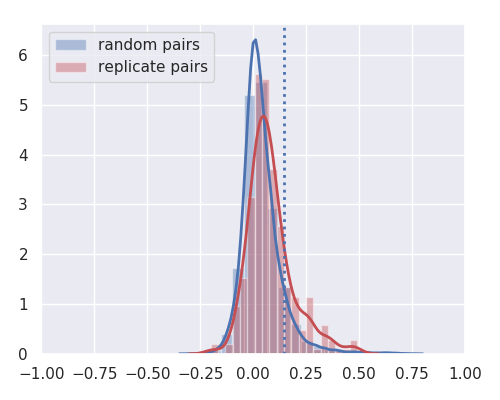

In [6]:
df1=taorf_l1k_df2[taorf_l1k_df2['pert_id']!='CMAP-000']
x=replicateCorrs(df1,'pert_id',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-taorf')

In [45]:
# cpFeatures=plateDfwMeta.columns[plateDfwMeta.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# cols2remove0=[i for i in l1k_features if ((df1[i]=='nan').sum(axis=0)/df1.shape[0])>0.05]
# print(cols2remove0)

# cols2remove1=l1k_features[df1[l1k_features].std().values<0.00001].tolist()
# cols2remove1
# sns.set(rc={"lines.linewidth": 2})
# randC_v2,repC,highRepPertbs=x[0],x[1],x[2]
# fig, axes = plt.subplots(figsize=(5,4))

# # sns.kdeplot(randC, bw=.1, label="random pairs",ax=axes)
# # sns.kdeplot(randC_v2, bw=.1, label="random pairs",ax=axes);axes.set_xlabel('CC');
# # sns.kdeplot(repC, bw=.1, label="replicate pairs",ax=axes,color='r');axes.set_xlabel('CC');

# sns.distplot(randC_v2,kde=True,hist=True,bins=20,label="random pairs",ax=axes,norm_hist=True);
# sns.distplot(repC,kde=True,hist=True,bins=20,label="replicate pairs",ax=axes,norm_hist=True,color='r');   

# #         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
# perc95=np.percentile(randC_v2, 90);axes.axvline(x=perc95,linestyle=':');
# axes.legend(loc=2);#axes.set_title('');
# axes.set_xlim(-0.8,0.8);
# plt.tight_layout()    

/home/marziehhaghighi/workspace_rosetta/workspace/software/2018_04_20_Rosetta/utils/replicateCorrs.py:44: RuntimeWarning: Mean of empty slice
  #         print(repCorr)


<IPython.core.display.Javascript object>


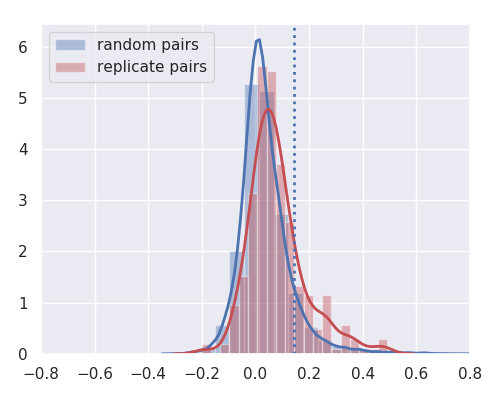

In [36]:
x=replicateCorrs(df1,'pert_id',l1k_features,1)

In [49]:
# taorf_l1k_df2['pert_id'].unique()

# x=replicateCorrs(df1,'pert_id',l1k_features,1)

In [50]:
# reload(replicateCorrs)
# x=replicateCorrs(df1,'pert_id',l1k_features,1)

In [72]:
# taorf_l1k_df2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/replicate_level_l1k.csv',index=False)
# taorf_l1k_df2.groupby(['x_genesymbol_mutation']).size()

In [61]:
ls ~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/L1000/

replicate_level_l1k.csv        replicate_level_l1k_ZSPCQNORM.csv
replicate_level_l1k_QNORM.csv


In [208]:
x[2].to_excel(writer, index=False, sheet_name='l1k-taorf')
writer.save()

#### L1000 - CDRP

In [9]:
os.listdir(rawProf_dir+'/l1000_CDRP/')

['Broad.PNAS2014.ProfilingData',
 'cdrp.well.prof.mat',
 'cdrp.all.prof.mat',
 'cdrp.well.metadata.mat',
 'cdrp.cpd.prof.mat',
 'cdrp.well.pczscore.mat',
 'wawer.gene.all.prof.rds']

In [56]:
rawProf_dir

'/storage/data/marziehhaghighi/Rosetta/raw-profiles/'

In [10]:
cdrp_dataDir=rawProf_dir+'/l1000_CDRP/'
cpd_info = pd.read_csv(cdrp_dataDir+"/Broad.PNAS2014.ProfilingData/compounds.txt", sep="\t", dtype=str)
cpd_info.columns

Index(['BROAD_CPD_ID', 'CPD_NAME', 'CPD_TYPE', 'CPD_SMILES'], dtype='object')

In [12]:
## Replicate level profiles
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# readRDS = robjects.r['readRDS']

# # load RDS files generated by "data_prepration_reproducible.Rmd"
# df_1 = readRDS(cdrp_dataDir+'wawer.gene.all.prof.rds')
# df_1 = pandas2ri.rpy2py_dataframe(df_1)
# df_1.head()

from scipy.io import loadmat
x = loadmat(cdrp_dataDir+'cdrp.all.prof.mat')

In [12]:
x.keys()

dict_keys(['__header__', '__version__', '__globals__', 'metaCpd', 'metaGen', 'metaNom', 'metaWell', 'nC', 'nG', 'nN', 'nW', 'pclfc', 'pclfc_mean', 'pczscore', 'pczscore_stouffer', 'vclfc', 'vczscore'])

In [6]:
k1=x['metaWell']['pert_id'][0][0]
k2=x['metaGen']['AFFX_PROBE_ID'][0][0]
k3=x['metaWell']['pert_dose'][0][0]
# pert_dose
# x['metaWell']['pert_id'][0][0][0][0][0]
pertID = []
probID=[]
for r in range(len(k1)):
    v = k1[r][0][0]
    pertID.append(v)
#     probID.append(k2[r][0][0])

for r in range(len(k2)):
    probID.append(k2[r][0][0])
    
dataArray=x['pclfc'];
cdrp_l1k_rep = pd.DataFrame(data=dataArray,columns=probID)
cdrp_l1k_rep['pert_id']=pertID
cdrp_l1k_rep['pert_dose']=k3
cdrp_l1k_rep['BROAD_CPD_ID']=cdrp_l1k_rep['pert_id'].str[:13]
cdrp_l1k_rep2=pd.merge(cdrp_l1k_rep, cpd_info, how='left',on=['BROAD_CPD_ID'])
l1k_features_cdrp=cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains("_at")]
# cdrp_l1k_df.head()
print(cpd_info.shape,cdrp_l1k_rep.shape,cdrp_l1k_rep2.shape)
cdrp_l1k_rep2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/replicate_level_l1k.csv.gz',index=False,compression='gzip')
cdrp_l1k_rep2.head()

NameError: name 'x' is not defined

In [5]:
cdrp_l1k_rep2

NameError: name 'cdrp_l1k_rep2' is not defined

In [31]:
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>3].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')

In [78]:
# cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().describe()
repSizeDF[repSizeDF['BROAD_CPD_ID']=='BRD-K43797669']

,BROAD_CPD_ID,0
10242,BRD-K43797669,193


In [87]:
repSizeDF[repSizeDF[0]>3].sort_values(by=[0])

,BROAD_CPD_ID,0
16309,BRD-K72676686,5
16179,BRD-K72034655,5
2831,BRD-K08438429,5
5933,BRD-K23383398,5
1089,BRD-K00007652,5
...,...,...
16159,BRD-K71879491,190
10242,BRD-K43797669,193
5008,BRD-K18910433,193
2202,BRD-K05396879,715


In [58]:
l1k_features_cdrp=cdrp_l1k_rep2.columns[cdrp_l1k_rep2.columns.str.contains("_at")]
# l1k_features_cdrp

In [59]:
# cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)].groupby('BROAD_CPD_ID')[['221227_x_at','212345_s_at','218597_s_at','205500_at']]
# inDf.groupby(pertColName)[featColNames]

In [103]:
repSizeDF.sample(4).reset_index(drop=True)

,BROAD_CPD_ID,0
0,BRD-K31147195,2
1,BRD-K47551852,3
2,BRD-K78556523,3
3,BRD-K68143200,2


In [18]:
# highRepComp
writer = pd.ExcelWriter(procProf_dir+'results/RepCor/'+fileName+'.xlsx', engine='xlsxwriter')
x[2].to_excel(writer, sheet_name='l1k-cdrp')
writer.save()

In [28]:
# import saveAsNewSheetToExistingFile


#### Check Replicate Correlation

<IPython.core.display.Javascript object>


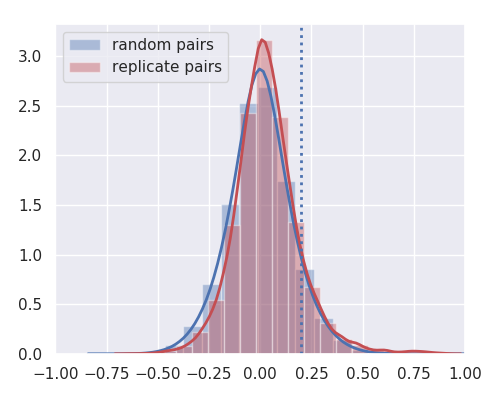

In [14]:
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')
x=utils.replicateCorrs.replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)],\
                                      'BROAD_CPD_ID',l1k_features_cdrp,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-cdrp')

<IPython.core.display.Javascript object>


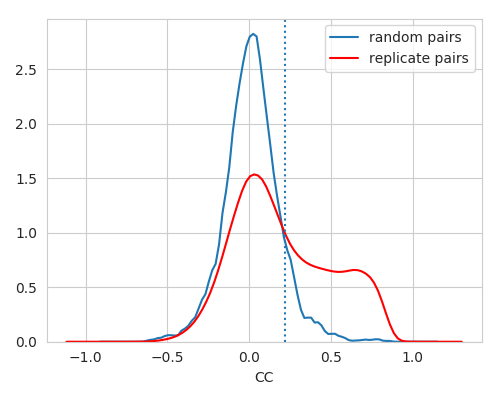

In [9]:
# import utils.replicateCorrs.replicateCorrs
import utils.replicateCorrs
reload(utils.replicateCorrs)
repSizeDF=cdrp_l1k_rep2.groupby(['BROAD_CPD_ID']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>3].BROAD_CPD_ID.tolist()
highRepComp.remove('DMSO')
# highRepComp.remove('BRD-K43797669')
x=utils.replicateCorrs.replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID'].isin(highRepComp)],\
                                      'BROAD_CPD_ID',l1k_features_cdrp,1)

In [ ]:
x=replicateCorrs(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']!='DMSO'],'BROAD_CPD_ID',l1k_features,1)

In [1]:
# cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'].corrwith(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K43797669'],\
#                                                                        axis = 1,method='pearson').values.tolist()

In [107]:
cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'].corrwith(cdrp_l1k_rep2[cdrp_l1k_rep2['BROAD_CPD_ID']=='BRD-K00007652'],\
                                                                       axis = 1,method='pearson').values.tolist()

[1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999]

In [172]:
# k3=x['metaWell']['pert_dose'][0][0]
# cdrp_l1k_rep['pert_id']=pertID
# cdrp_l1k_rep['pert_dose']=k3
# cdrp_l1k_rep['BROAD_CPD_ID']=cdrp_l1k_rep['pert_id'].str[:13]
# cdrp_l1k_rep2=pd.merge(cdrp_l1k_rep, cpd_info, how='left',on=['BROAD_CPD_ID'])
# # cdrp_l1k_df.head()
# print(cpd_info.shape,cdrp_l1k_rep.shape,cdrp_l1k_rep2.shape)
# cdrp_l1k_rep2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/replicate_level_l1k.csv',index=False)
# cdrp_l1k_rep2.head()

In [16]:
# treatmentLevel
cdrp_l1k = parse(cdrp_dataDir+"Broad.PNAS2014.ProfilingData/ge.profiles_n21983x977.gctx")
cdrp_l1k_df=cdrp_l1k.data_df.T.reset_index()
cdrp_l1k_df['XX']=cdrp_l1k_df['cid'].str[0]
cdrp_l1k_df['BROAD_CPD_ID']=cdrp_l1k_df['cid'].str[2:15]
cdrp_l1k_df2=pd.merge(cdrp_l1k_df, cpd_info, how='inner',on=['BROAD_CPD_ID'])
# cdrp_l1k_df.head()
print(cpd_info.shape,cdrp_l1k_df.shape,cdrp_l1k_df2.shape)
cdrp_l1k_df2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/L1000/treatment_level_l1k.csv.gz',index=False,compression='gzip')

(32324, 4) (21983, 980) (21983, 983)


In [17]:
cdrp_l1k_df2.head()

,cid,221227_x_at,212345_s_at,218597_s_at,217140_s_at,209253_at,214404_x_at,219888_at,201225_s_at,202535_at,...,202801_at,206414_s_at,204978_at,205379_at,203897_at,XX,BROAD_CPD_ID,CPD_NAME,CPD_TYPE,CPD_SMILES
0,1:BRD-K89732114-300-06-3,-815.848145,372.501862,-439.068542,-201.406067,-269.752014,265.633698,-7.044870,-23.993784,-443.847992,...,-2.519104,-103.996338,21.385452,8.454297,-13.765161,1,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
1,2:BRD-K89732114-300-06-3,-684.512024,488.680786,-442.240326,-170.592804,-271.027771,354.551361,113.733376,-110.299194,-679.035767,...,39.128761,-99.362427,96.397514,209.599640,-66.092232,2,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
2,3:BRD-K89732114-300-07-1,-332.084930,413.534698,-285.547913,-292.624268,-214.678284,92.443077,181.307755,-208.432419,-428.033112,...,-108.442131,-14.973925,11.643245,79.470329,-0.310117,3,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
3,4:BRD-K89732114-300-07-1,-1093.123169,1363.475464,-720.515137,-359.339844,-815.420654,366.414734,88.413223,-367.906738,-1077.626831,...,-77.961143,280.649933,-257.341980,434.858887,-291.218781,4,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1
4,5:BRD-K89732114-300-07-1,-2170.005859,1454.608276,-2649.765137,-933.394348,-1507.882690,1872.741455,945.424927,-395.551941,-2420.134766,...,1229.749268,839.844727,-591.371643,1262.786499,-590.441895,5,BRD-K89732114,trifluoperazine,POS,CN1CCN(CCCN2c3ccccc3Sc3ccc(cc23)C(F)(F)F)CC1


In [107]:
# cdrp_l1k_df2.head()
# cdrp_l1k.head()
# cdrp_l1k_df2.groupby(['BROAD_CPD_ID']).size().mean()
# cdrp_l1k_df2.groupby(['CPD_NAME']).size()

#### L1000 - LUAD

In [8]:
os.listdir(rawProf_dir+'/l1000_LUAD/input/')

['lung_control_x_mutation_status.grp',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_conn_null.txt',
 'high_rep_A549_8reps_141230_eVIP_compare_150421_rep_null.txt',
 'TA.OE015_A549_96H.map',
 'TA.OE014_A549_96H.map',
 'TA.OE014_A549_96H_ZSPCINF_n2939x22268.gctx',
 'TA.OE015_A549_96H_ZSPCINF_n3006x22268.gctx',
 'TA.Lung_intended_clone_info_150406_confirmations_150407_WT_reference_calls_150420_ref2allele.txt',
 'landmark_probe_ids.grp']

In [9]:
os.listdir(rawProf_dir+'/l1000_LUAD/output/')

['high_rep_A549_8reps_141230.log',
 'high_rep_A549_8reps_141230_n529x22268.gctx',
 'grp_files_141230',
 'high_rep_A549_ZSPCINF_141208_n5945x22268.gctx',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x22268.gctx',
 'high_rep_A549_8reps_141230_sig.info',
 'high_rep_A549_inst_final_141207.txt',
 'high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx',
 'high_rep_A549_8reps_141230_COMPZ.MODZ_n529x978.gctx']

In [10]:
luad_dataDir=rawProf_dir+'/l1000_LUAD/'
luad_info1 = pd.read_csv(luad_dataDir+"/input/TA.OE014_A549_96H.map", sep="\t", dtype=str)
luad_info2 = pd.read_csv(luad_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
luad_info=pd.concat([luad_info1, luad_info2], ignore_index=True)
luad_info.head()

,id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mutation_status,x_not_empty,x_number_orfs_per_gene,x_open_closed,x_orf_numbername,x_preferredgenename,x_protein_match,x_transcriptdb,zmad_ref,zmad_ref_well
0,TA.OE014_A549_96H_X1_B19:A03,b19,r2,"dp52,dp53",A549,25,33,duo,TA.OE014_A549_96H_X1_B19,A03,...,ACAT2_WT.o,-666,2,open,ORF017110.1_TRC317.1,acetoacetyl Coenzyme A thiolase|acetyl-CoA ace...,99.7,NM_005891.2,population,all
1,TA.OE014_A549_96H_X1_B19:A04,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A04,...,EBNA1BP2_WT.o,-666,2,open,ORF006664.1_TRC317.1,EBNA1-binding protein 2|nuclear FGF3 binding p...,100,NM_006824.2,population,all
2,TA.OE014_A549_96H_X1_B19:A05,b19,r2,"dp52,dp53",A549,25,41,duo,TA.OE014_A549_96H_X1_B19,A05,...,BFP,-666,16,open,ORFC00001.1_TRC317.1,BFP,100,BFP.1,population,all
3,TA.OE014_A549_96H_X1_B19:A06,b19,r2,"dp52,dp53",A549,25,35,duo,TA.OE014_A549_96H_X1_B19,A06,...,HCRED,-666,16,open,ORFC00002.1_TRC317.1,HcRed,100,HcRed.1,population,all
4,TA.OE014_A549_96H_X1_B19:A07,b19,r2,"dp52,dp53",A549,24,55,duo,TA.OE014_A549_96H_X1_B19,A07,...,ABCB9_WT.c,-666,5,close,ORF024050.1_TRC317.1,ABC transporter 9 protein|ATP-binding cassette...,85.6,NM_001243014.1,population,all


In [53]:
# luad_info.shape

In [116]:
# luad_info2.x_mutation_status.unique()

In [11]:
luad_l1k_df = parse(luad_dataDir+"/output/high_rep_A549_8reps_141230_ZSPCINF_n4232x978.gctx").data_df.T.reset_index()
luad_l1k_df=luad_l1k_df.rename(columns={"cid":"id"})
# cdrp_l1k_df['XX']=cdrp_l1k_df['cid'].str[0]
# cdrp_l1k_df['BROAD_CPD_ID']=cdrp_l1k_df['cid'].str[2:15]
luad_l1k_df2=pd.merge(luad_l1k_df, luad_info, how='inner',on=['id'])
luad_l1k_df2=luad_l1k_df2.rename(columns={"x_mutation_status":"allele"})

l1k_features=luad_l1k_df2.columns[luad_l1k_df2.columns.str.contains("_at")]

print(luad_info.shape,luad_l1k_df.shape,luad_l1k_df2.shape)
# luad_l1k_df2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/LUAD-BBBC041-Caicedo/L1000/replicate_level_l1k.csv.gz',index=False,compression='gzip')

(5945, 54) (4232, 979) (4232, 1032)


In [12]:
# luad_l1k_df2.allele.unique()
luad_l1k_df2.columns

Index(['id', '201000_at', '203192_at', '209380_s_at', '200045_at',
       '202394_s_at', '218581_at', '221552_at', '202123_s_at', '214274_s_at',
       ...
       'allele', 'x_not_empty', 'x_number_orfs_per_gene', 'x_open_closed',
       'x_orf_numbername', 'x_preferredgenename', 'x_protein_match',
       'x_transcriptdb', 'zmad_ref', 'zmad_ref_well'],
      dtype='object', length=1032)

In [118]:
luad_l1k_df2.groupby(['allele']).size()

allele
ABCB9_WT.c        8
ABCB9_WT.o        8
ABCB9_p.R281L     8
ABCB9_p.V140M     8
ACAA1_WT.o        8
                 ..
ZNF597_WT.o       8
ZNF597_p.F16L     8
ZNF597_p.L283V    8
ZNF597_p.R247T    8
ZNF597_p.V21L     8
Length: 529, dtype: int64

<IPython.core.display.Javascript object>


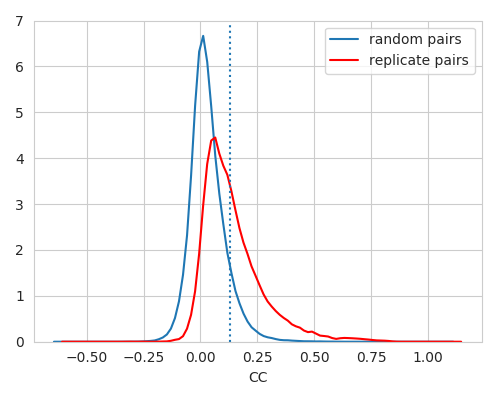

In [35]:
# x=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='UnTrt'].reset_index(drop=True).sample(100),'allele',l1k_features,1)
x=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='UnTrt'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-luad')

<IPython.core.display.Javascript object>


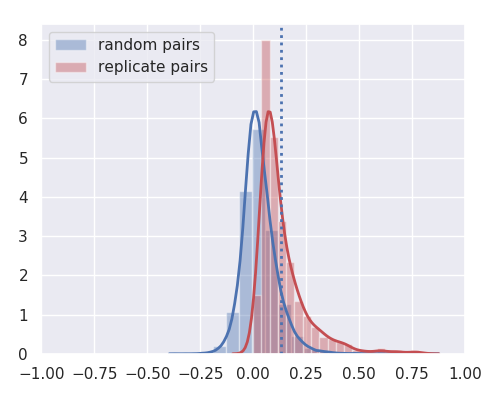

In [12]:
x=replicateCorrs(luad_l1k_df2[luad_l1k_df2['allele']!='UnTrt'].reset_index(drop=True),'allele',l1k_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'l1k-luad')

In [42]:
len(set(luad_l1k_df.id)-set(luad_info.id)), len(set(luad_info.id)-set(luad_l1k_df.id))

(0, 1713)

In [20]:
np.sum([x[1][i]==np.nan for i in range(len(x[1]))])

0

In [276]:
# cdrp_l1k_df.groupby(['BROAD_CPD_ID']).size()
# gene_info['CPD_TYPE'].unique()

### L1000 - LINCS

In [9]:
os.listdir(rawProf_dir+'/l1000_LINCS/2016_04_01_a549_48hr_batch1_L1000/')

['figures',
 'level_3_q2norm_n27837x978.gctx',
 'level_4W_zspc_n27837x978.gctx',
 'level_4_zspc_n27837x978.gctx',
 'level_5_modz_cid_n9482.grp',
 'level_5_modz_common_sigs_n8370x978.gctx',
 'level_5_modz_n9482x978.gctx',
 'level_5_rank_n9482x978.gctx',
 'steep_nohup.out']

In [8]:
os.listdir(rawProf_dir+'/l1000_LINCS/metadata/')

['REP.A_A549_pert_info.txt',
 'col_meta_level_3_REP.A_A549_only_n27837.txt',
 'col_meta_level_3_n421176.txt',
 'col_meta_level_5_REP.A_A549_only_n9482.txt',
 'col_meta_level_5_n169494.txt',
 'other_cell_lines',
 'set_size_3_level_3_REP.A_A549_only_all_compounds_and_random_well_DMSO.gmt']

In [34]:
data_meta_match_ls=[['level_3','level_3_q2norm_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4W','level_4W_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_4','level_4_zspc_n27837x978.gctx','col_meta_level_3_REP.A_A549_only_n27837.txt'],
                   ['level_5_modz','level_5_modz_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt'],
                   ['level_5_rank','level_5_rank_n9482x978.gctx','col_meta_level_5_REP.A_A549_only_n9482.txt']]

In [33]:
lincs_dataDir=rawProf_dir+'/l1000_LINCS/'
lincs_pert_info = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
lincs_meta_level3 = pd.read_csv(lincs_dataDir+"/metadata/col_meta_level_3_REP.A_A549_only_n27837.txt", sep="\t", dtype=str)
# lincs_info1 = pd.read_csv(lincs_dataDir+"/metadata/REP.A_A549_pert_info.txt", sep="\t", dtype=str)
print(lincs_meta_level3.shape)
lincs_meta_level3.head()
# lincs_info2 = pd.read_csv(lincs_dataDir+"/input/TA.OE015_A549_96H.map", sep="\t", dtype=str)
# lincs_info=pd.concat([lincs_info1, lincs_info2], ignore_index=True)
# lincs_info.head()

(27837, 45)


,distil_id,bead_batch,bead_revision,bead_set,cell_id,count_cv,count_mean,det_mode,det_plate,det_well,...,x_mg_per_ml,x_mmoles_per_liter,x_purity,x_smiles,x_volume_ul,pert_plate,batch,nearest_dose,brew_prefix,group_id
0,REP.A001_A549_24H_X1_B27:A03,b27,r2,"dp52,dp53",A549,39,93,duo,REP.A001_A549_24H_X1_B27,A03,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A03
1,REP.A001_A549_24H_X1_B27:A04,b27,r2,"dp52,dp53",A549,41,67,duo,REP.A001_A549_24H_X1_B27,A04,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A04
2,REP.A001_A549_24H_X1_B27:A05,b27,r2,"dp52,dp53",A549,39,109,duo,REP.A001_A549_24H_X1_B27,A05,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A05
3,REP.A001_A549_24H_X1_B27:A06,b27,r2,"dp52,dp53",A549,38,117,duo,REP.A001_A549_24H_X1_B27,A06,...,-666,-666,-666,-666,13,REP.A001,REP.A,-666,REP.A001_A549_24H,REP.A001_A549_24H:A06
4,REP.A001_A549_24H_X1_B27:A07,b27,r2,"dp52,dp53",A549,40,89,duo,REP.A001_A549_24H_X1_B27,A07,...,1.10546,10,100,NNC(N)=N,13,REP.A001,REP.A,10,REP.A001_A549_24H,REP.A001_A549_24H:A07


In [44]:
# lincs_meta_level3.columns.tolist()
# lincs_meta_level3.pert_id

In [43]:
ls /home/ubuntu/workspace_rosetta/workspace/software/2018_04_20_Rosetta/preprocessed_data/LINCS-Pilot1/CellPainting

CellPainting/  L1000/


In [41]:
procProf_dir+'preprocessed_data/LINCS-Pilot1/'

'./preprocessed_data/LINCS-Pilot1/'

In [38]:
for el in data_meta_match_ls:
    lincs_l1k_df=parse(lincs_dataDir+"/2016_04_01_a549_48hr_batch1_L1000/"+el[1]).data_df.T.reset_index()
    lincs_meta0 = pd.read_csv(lincs_dataDir+"/metadata/"+el[2], sep="\t", dtype=str)
    lincs_meta=pd.merge(lincs_meta0, lincs_pert_info, how='left',on=['pert_id'])
    lincs_meta=lincs_meta.rename(columns={"distil_id":"cid"})
    lincs_l1k_df2=pd.merge(lincs_l1k_df, lincs_meta, how='inner',on=['cid'])
    lincs_l1k_df2.to_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+el[0]+'.csv.gz',index=False,compression='gzip')

<IPython.core.display.Javascript object>


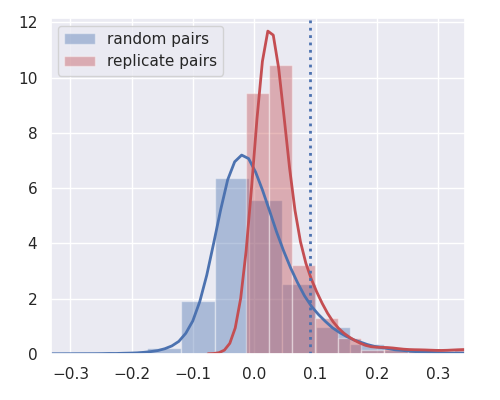

In [51]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[1][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)
# saveAsNewSheetToExistingFile(filename,x[2],'l1k-lincs')
# lincs_l1k_rep.head()

In [48]:
lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains('pert')]

Index(['pert_dose', 'pert_dose_unit', 'pert_id', 'pert_id_vendor',
       'pert_idose', 'pert_iname_x', 'pert_itime', 'pert_mfc_desc',
       'pert_mfc_id', 'pert_time', 'pert_time_unit', 'pert_type_x',
       'pert_vehicle', 'pert_plate', 'pert_iname_y', 'pert_type_y'],
      dtype='object')

<IPython.core.display.Javascript object>


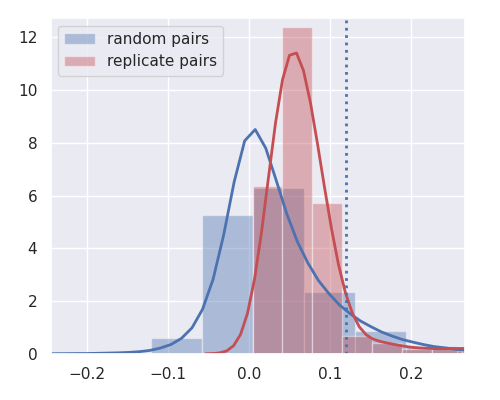

In [52]:
lincs_l1k_rep = pd.read_csv(procProf_dir+'preprocessed_data/LINCS-Pilot1/L1000/'+data_meta_match_ls[2][0]+'.csv.gz')
l1k_features=lincs_l1k_rep.columns[lincs_l1k_rep.columns.str.contains("_at")]
x=replicateCorrs(lincs_l1k_rep[lincs_l1k_rep['pert_iname_x']!='DMSO'].reset_index(drop=True),'pert_id',l1k_features,1)

### Reformat Cell-Painting Data Sets

raw data
- CDRP and TA-ORF are in /storage/data/marziehhaghighi/Rosetta/raw-profiles/
- Luad is already processed by Juan, source of the files is at /storage/luad/profiles_cp
 in case you want to reformat

#### CP - LUAD

In [102]:
ls /storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/52649/

52649.csv     52649_augmented.csv   52649_normalized_variable_selected.csv
52649.sqlite  52649_normalized.csv  52649_normalized_variable_selected.gct


In [5]:
Y1=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp.csv')
# Juan preprocessed df .   New
# 'Allele'      ----->    'x_mutation_status'
# 'Category'    ----->    ''??
# 'Clone ID'    ----->    'PublicID'
# 'Gene Symbol' ----->    'Symbol'

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/')
for pt in profileType[1:2]:
    repLevelLuad0=[]
    for p in plates:
        repLevelLuad0.append(pd.read_csv('/storage/luad/profiles_cp/LUAD-BBBC043-Caicedo/'+p+'/'+p+pt+'.csv'))
    repLevelLuad = pd.concat(repLevelLuad0)
    metaLuad1=pd.read_csv(rawProf_dir+'/CP_LUAD/metadata/combined_platemaps_AHB_20150506_ssedits.csv')
    metaLuad1=metaLuad1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    metaLuad1['Metadata_Well']=metaLuad1['Metadata_Well'].str.lower()
    # metaLuad2=pd.read_csv('~/workspace_rosetta/workspace/raw_profiles/CP_LUAD/metadata/barcode_platemap.csv')
    # Y[Y['Metadata_Well']=='g05']['Nuclei_Texture_Variance_Mito_5_0']
    repLevelLuad2=pd.merge(repLevelLuad, metaLuad1, how='inner',on=['Metadata_Plate_Map_Name','Metadata_Well'])
    cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
#     repLevelLuad2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/LUAD-BBBC041-Caicedo/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    print(metaLuad1.shape,repLevelLuad.shape,repLevelLuad2.shape)    

(1152, 14) (6144, 1802) (6144, 1814)


In [62]:
# print(repLevelLuad2.shape,Y1.shape)
# repLevelLuad2['x_mutation_status'].unique()
# repLevelLuad2
# df1

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_

<IPython.core.display.Javascript object>


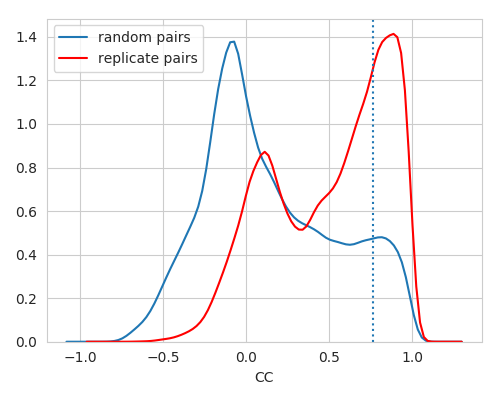

In [63]:
# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
repLevelLuad2 = repLevelLuad2.interpolate()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'x_mutation_status',cp_features,1)

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_

<IPython.core.display.Javascript object>


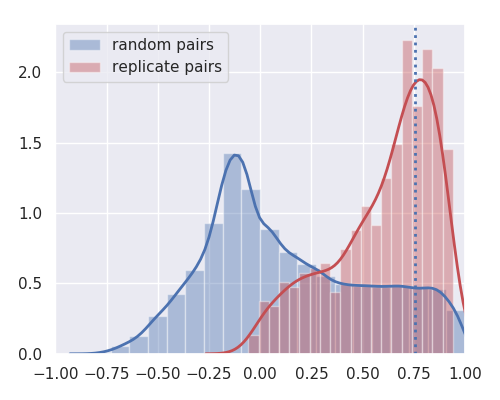

In [23]:
# repLevelTA.head()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelLuad2[i].isnull()).sum(axis=0)/repLevelLuad2.shape[0])>0.05]
print(cols2remove0)
repLevelLuad2=repLevelLuad2.drop(cols2remove0, axis=1);
repLevelLuad2 = repLevelLuad2.interpolate()
cp_features=repLevelLuad2.columns[repLevelLuad2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelLuad2[~repLevelLuad2['x_mutation_status'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'x_mutation_status',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-luad')

In [66]:
luadCPHighRepAlelles=x[2]
# set(Y1.columns)-set(repLevelLuad2)

In [67]:
list(set(luadCPHighRepAlelles) & set(luadL1kHighRepAlelles)) 

['PTEN_p.M35I',
 'KEAP1_p.E218V',
 'KEAP1_p.V99L',
 'KRAS_p.G12R',
 'TP53_p.R249M',
 'CTNNB1_p.G34V',
 'RBM45_p.D434Y',
 'RARA_p.D256Y',
 'KEAP1_p.L268P',
 'TPK1_p.L185I',
 'MRPS16_WT.o',
 'MYC_p.N215I',
 'EGFR_p.V769L',
 'MAX_p.R60del',
 'TP53_p.D281Y',
 'KEAP1_WT.o',
 'CCND1_WT.c',
 'PSMG1_WT.o',
 'CTNNB1_p.S37C',
 'PIK3R3_p.R245C',
 'CTNNB1_p.S33N',
 'TSTA3_WT.o',
 'TP53_p.R181H',
 'ARAF_p.D429A',
 'GABPB1_WT.o',
 'DNAJC15_WT.o',
 'TPK1_p.K111M',
 'PIK3R3_WT.o',
 'RBM45_p.M126I',
 'KEAP1_p.G364C',
 'EGFR_p.S921R',
 'TPK1_p.P152T',
 'ABCB9_WT.o',
 'KEAP1_p.F139L',
 'RBM45_WT.c',
 'MAX_WT.c',
 'EGFR_p.L907M',
 'ARAF_p.V145L',
 'KEAP1_p.S144F',
 'KEAP1_p.G333S',
 'MAX_p.R35L',
 'ID2_WT.o',
 'EGFR_p.R1052I',
 'LAGE3_WT.o',
 'EGFR_p.S645C',
 'AKT1_p.D323Y',
 'KRAS_WT.c',
 'KEAP1_p.D389Y',
 'TPK1_p.E81Q']

In [88]:
# set(repLevelLuad2)-set(Y1.columns)

In [100]:
# Y1[['Allele', 'Category', 'Clone ID', 'Gene Symbol']].head()

In [101]:
# repLevelLuad2[repLevelLuad2['PublicID']=='BRDN0000553807'][['Col','InsertLength','NCBIGeneID','Name','OtherDescriptions','PublicID','Row','Symbol','Transcript','Vector','pert_type','x_mutation_status']].head()

#### CP - CDRP

In [107]:
ls /storage/data/marziehhaghighi/Rosetta/raw-profiles/CDRP/24277/

24277.csv     24277_augmented.csv   24277_normalized_variable_selected.csv
24277.sqlite  24277_normalized.csv


In [5]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir('/storage/data/marziehhaghighi/Rosetta/raw-profiles/CDRP/')
for pt in profileType[1:2]:
    repLevelCDRP0=[]
    for p in plates:
        repLevelCDRP0.append(pd.read_csv(rawProf_dir+'/CDRP/'+p+'/'+p+pt+'.csv'))
    repLevelCDRP = pd.concat(repLevelCDRP0)
    metaCDRP1=pd.read_csv(rawProf_dir+'/CP_CDRP/metadata/metadata_CDRP.csv')
    # metaCDRP1=metaCDRP1.rename(columns={"PlateName":"Metadata_Plate_Map_Name",'Well':'Metadata_Well'})
    # metaCDRP1['Metadata_Well']=metaCDRP1['Metadata_Well'].str.lower()
    repLevelCDRP2=pd.merge(repLevelCDRP, metaCDRP1, how='left',on=['Metadata_broad_sample'])
#     repLevelCDRP2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    print(metaCDRP1.shape,repLevelCDRP.shape,repLevelCDRP2.shape)

(1553, 5) (153370, 1800) (153386, 1804)


In [71]:
repLevelCDRP2.Metadata_broad_sample.unique().tolist()

['BRD-K36986252-001-01-6',
 'BRD-K13462310-001-01-5',
 'BRD-K46085646-001-01-0',
 'BRD-K88812688-001-01-5',
 'BRD-K05041765-001-01-7',
 'BRD-K68758594-001-01-7',
 'BRD-K22651517-001-02-1',
 'BRD-K63394284-001-01-1',
 'BRD-K93785828-001-01-7',
 'BRD-K97784715-001-01-2',
 'BRD-K91202220-001-02-7',
 'BRD-K39978929-001-01-3',
 'DMSO',
 'BRD-K08966355-001-01-8',
 'BRD-K96713984-001-01-6',
 'BRD-K52441396-001-01-8',
 'BRD-K24930745-001-01-3',
 'BRD-K01899298-001-01-8',
 'BRD-K32854540-001-01-2',
 'BRD-K12492021-001-01-3',
 'BRD-K31852848-001-01-6',
 'BRD-K97732674-001-01-0',
 'BRD-K86942117-001-01-3',
 'BRD-K43289649-001-01-8',
 'BRD-K36219645-001-02-6',
 'BRD-K87690520-001-01-8',
 'BRD-K31001397-001-01-5',
 'BRD-K73523458-001-01-3',
 'BRD-K90821428-001-01-7',
 'BRD-K55800245-001-01-5',
 'BRD-K08355771-001-01-0',
 'BRD-K37770214-001-01-0',
 'BRD-K32839286-001-01-1',
 'BRD-K11168234-001-01-3',
 'BRD-K47498351-001-01-9',
 'BRD-K63937112-001-01-5',
 'BRD-K51697562-001-01-4',
 'BRD-K76487707-001

In [ ]:
metaCDRP1[metaCDRP1['Metadata_broad_sample']=='BRD-A01320529-001-05-9'] 
# BRD-A13084692-001-05-8

#### Check Replicate Correlation

In [74]:
# repLevelTA.head()
cp_features=repLevelCDRP2.columns[repLevelCDRP2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelCDRP2[i].isnull()).sum(axis=0)/repLevelCDRP2.shape[0])>0.05]
print(cols2remove0)
repLevelCDRP3=repLevelCDRP2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelCDRP3 = repLevelCDRP3.interpolate()
cp_features=repLevelCDRP3.columns[repLevelCDRP3.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
# df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample']!='DMSO'].reset_index(drop=True)
repSizeDF=repLevelCDRP3.groupby(['Metadata_broad_sample']).size().reset_index()
highRepComp=repSizeDF[repSizeDF[0]>1].Metadata_broad_sample.tolist()
highRepComp.remove('DMSO')
df0=repLevelCDRP3[repLevelCDRP3['Metadata_broad_sample'].isin(highRepComp)]
# x=replicateCorrs(df0,'Metadata_broad_sample',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-cdrp')

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_Mito', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_DNA', 'Cells_Correlation_Manders_AGP_ER', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_AGP_RNA', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_ER', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_DNA_RNA', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Correlation_Mand

<IPython.core.display.Javascript object>


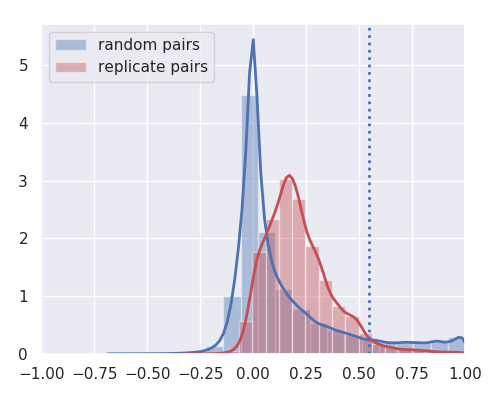

In [57]:
# cp_features
# import random
# random.sample(featColNames.tolist(),100)
# featColNames.tolist()
# randC_v2

repC=repCorrDf.RepCor.values
repC = [repC for repC in repC if str(repC) != 'nan']
randC_v2 = [randC_v2 for randC_v2 in randC_v2 if str(randC_v2) != 'nan']    
if plotEnabled:
    fig, axes = plt.subplots(figsize=(5,4))
#         sns.kdeplot(randC_v2, bw=.1, label="random pairs",ax=axes);axes.set_xlabel('CC');
#         sns.kdeplot(repC, bw=.1, label="replicate pairs",ax=axes,color='r');axes.set_xlabel('CC');
    sns.distplot(randC_v2,kde=True,hist=True,bins=20,label="random pairs",ax=axes,norm_hist=True);
    sns.distplot(repC,kde=True,hist=True,bins=20,label="replicate pairs",ax=axes,norm_hist=True,color='r');   

    #         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
    axes.axvline(x=perc95,linestyle=':');
    axes.legend(loc=2);#axes.set_title('');
    axes.set_xlim(-1,1);
    plt.tight_layout() 

repCorrDf['Rand90Perc']=perc95

In [79]:
repCorrDf3=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_corr_DF_'+pt+'.csv')

In [12]:
repCorrDf.to_csv('~/workspace_rosetta/workspace/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_corr_DF_'+pt+'.csv',index=False)

In [19]:
# repCorrDf

#### CP - TA-ORF

In [123]:
ls ~/workspace_rosetta/workspace/raw_profiles/CP_TA_ORF/metadata/

metadata_TA.csv  metadata_TA_2.csv


In [ ]:
# ls /storage/data/marziehhaghighi/Rosetta/raw-profiles/TA-ORF-BBBC037-Rohban/41757
# repLevelTA
# metaTA2

In [25]:
profileType=['_augmented','_normalized','_normalized_variable_selected']
plates=os.listdir('/storage/data/marziehhaghighi/Rosetta/raw-profiles/TA-ORF-BBBC037-Rohban/')
for pt in profileType[1:2]:
    repLevelTA0=[]
    for p in plates:
        repLevelTA0.append(pd.read_csv('/storage/data/marziehhaghighi/Rosetta/raw-profiles/TA-ORF-BBBC037-Rohban/'+p+'/'+p+pt+'.csv'))
    repLevelTA = pd.concat(repLevelTA0)
    metaTA1=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA.csv')
    metaTA2=pd.read_csv(rawProf_dir+'/CP_TA_ORF/metadata/metadata_TA_2.csv')
#     metaTA2=metaTA2.rename(columns={"Metadata_broad_sample":"Metadata_broad_sample_2",'Metadata_Treatment':'Gene Allele Name'})
    metaTA=pd.merge(metaTA2, metaTA1, how='left',on=['Metadata_broad_sample'])
#     metaTA2=metaTA2.rename(columns={"Metadata_Treatment":"Metadata_pert_name"})
#     repLevelTA2=pd.merge(repLevelTA, metaTA2, how='left',on=['Metadata_pert_name'])
    repLevelTA2=pd.merge(repLevelTA, metaTA, how='left',on=['Metadata_broad_sample'])

#     repLevelTA2=repLevelTA2.rename(columns={"Gene Allele Name":"Allele"})
#     repLevelTA2.to_csv('~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp'+pt+'.csv.gz',index=False,compression='gzip')
    print(metaTA.shape,repLevelTA.shape,repLevelTA2.shape)


(323, 4) (1920, 1801) (1920, 1804)


In [4]:
pt

'_normalized'

In [116]:
repLevelTA[repLevelTA['Metadata_broad_sample'].isnull()]['Metadata_pert_name'].unique()

array(['EMPTY_', 'Luciferase_CTRL', 'LacZ_CTRL', 'eGFP_CTRL'],
      dtype=object)

In [50]:
df1[cp_features].isnull().sum().sum()

166594

In [75]:
[i for i in cp_features2 if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0]

[]

In [74]:
cp_features2=list(set(cp_features)-set(cols2remove0))

In [4]:
cp_features

NameError: name 'cp_features' is not defined

#### Check Replicate Correlation

['Cells_AreaShape_EulerNumber', 'Cells_Children_Cytoplasm_Count', 'Cells_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_AGP_Mito', 'Cells_Correlation_Costes_AGP_RNA', 'Cells_Correlation_Costes_DNA_AGP', 'Cells_Correlation_Costes_DNA_ER', 'Cells_Correlation_Costes_DNA_Mito', 'Cells_Correlation_Costes_DNA_RNA', 'Cells_Correlation_Costes_ER_AGP', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_ER_Mito', 'Cells_Correlation_Costes_ER_RNA', 'Cells_Correlation_Costes_Mito_AGP', 'Cells_Correlation_Costes_Mito_DNA', 'Cells_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_Mito_RNA', 'Cells_Correlation_Costes_RNA_AGP', 'Cells_Correlation_Costes_RNA_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_RNA_Mito', 'Cells_Correlation_Manders_AGP_Mito', 'Cells_Correlation_Manders_DNA_AGP', 'Cells_Correlation_Manders_DNA_Mito', 'Cells_Correlation_Manders_ER_AGP', 'Cells_Correlation_Manders_ER_Mito', 'Cells_Correlation_Manders_R

<IPython.core.display.Javascript object>


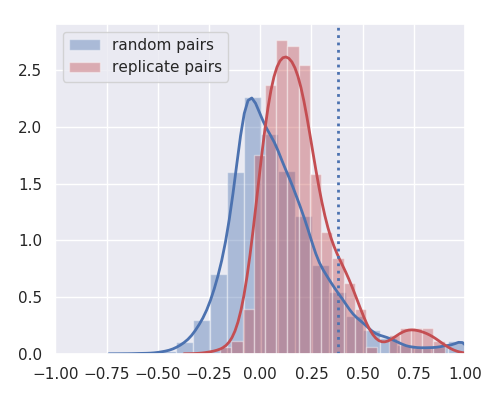

In [26]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)
saveAsNewSheetToExistingFile(filename,x[2],'cp-taorf')

In [146]:
# repLevelTA2['Metadata_pert_name'].unique().shape

In [145]:
# repLevelTA2[~repLevelTA2['Metadata_Treatment'].isnull()]

In [41]:
# metaTA2
# repLevelTA2.Metadata_broad_sample.unique()


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,Metadata_Treatment,Metadata_moa,Gene Allele Name
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.087757,0.134254,0.175410,0.164607,-0.003308,-0.022142,-0.004267,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.074576,0.198571,0.337069,0.267433,0.098321,0.171637,0.146302,TSC2_WT,TOR,TSC2_WT
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.426503,0.331142,0.493209,0.476443,-0.204066,-0.087844,-0.080835,BAX_WT,Apoptosis,BAX_WT
5,41757,a06,41757,TAORF_REFERENCE_SET,a06,VEGFC,VEGFC_WT.1,ccsbBroad304_07127,U2OS,Treated,...,0.164220,0.152590,0.189038,0.128034,-0.037912,0.044105,0.057332,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
6,41757,a07,41757,TAORF_REFERENCE_SET,a07,CCND1,CCND1_WT.1,ccsbBroad304_00155,U2OS,Treated,...,0.190452,0.109554,0.212599,0.172789,-0.028852,0.085257,0.051551,CCND1_WT.1,Cell Cycle,CCND1_WT.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907,41754,p12,41754,TAORF_REFERENCE_SET,p12,AKT2,AKT2_WT,ccsbBroad304_00047,U2OS,Treated,...,0.154834,0.072012,0.128960,0.126100,0.165125,0.157068,0.161339,AKT2_WT,NaN,NaN
1908,41754,p13,41754,TAORF_REFERENCE_SET,p13,XBP1,XBP1_S,BRDN0000464974,U2OS,Treated,...,0.150405,0.063452,0.130246,0.102279,0.007365,0.042932,0.040546,XBP1_S,NaN,NaN
1909,41754,p14,41754,TAORF_REFERENCE_SET,p14,RHOA,RHOA_WT,ccsbBroad304_00100,U2OS,Treated,...,0.232021,0.248644,0.271816,0.244374,0.081614,0.212082,0.189489,RHOA_WT,Cytoskeletal Re-org,RHOA_WT
1910,41754,p15,41754,TAORF_REFERENCE_SET,p15,RHOA,RHOA_T19N,BRDN0000464975,U2OS,Treated,...,0.197588,0.121507,0.160076,0.158204,0.052668,0.022378,0.044882,RHOA_T19N,NaN,NaN


In [143]:
# repLevelTA.head()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
cols2remove0=[i for i in cp_features if ((repLevelTA2[i].isnull()).sum(axis=0)/repLevelTA2.shape[0])>0.05]
print(cols2remove0)
repLevelTA2=repLevelTA2.drop(cols2remove0, axis=1);
# cp_features=list(set(cp_features)-set(cols2remove0))
# repLevelTA2=repLevelTA2.replace('nan', np.nan)
repLevelTA2 = repLevelTA2.interpolate()
cp_features=repLevelTA2.columns[repLevelTA2.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
df1=repLevelTA2[~repLevelTA2['Metadata_broad_sample'].isnull()].reset_index(drop=True)
x=replicateCorrs(df1,'Metadata_broad_sample',cp_features,1)

In [139]:
len(set(repLevelTA2['Metadata_broad_sample'])-set(taorf_l1k_df2['pert_id']))

175

In [83]:
repLevelTA2['Metadata_Treatment'].unique().shape

(324,)

In [169]:
ls ~/workspace_rosetta/workspace/preprocessed_data/

CDRPBIO-BBBC036-Bray/  LUAD-BBBC041-Caicedo/  TA-ORF-BBBC037-Rohban/


In [7]:
# np.sort(metaTA2['Metadata_Treatment'].unique())
repLevelTA2.head()

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_DifferenceVariance_ER_10_0,Nuclei_Texture_DifferenceVariance_RNA_3_0,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_3_0,Nuclei_Texture_InfoMeas1_ER_3_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_Variance_ER_10_0,Metadata_moa,Allele,Metadata_broad_sample_2
0,41757,a01,41757,TAORF_REFERENCE_SET,a01,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,0.183206,-0.856756,-0.862536,-0.461538,-0.447009,-0.146888,0.324970,NaN,NaN,NaN
1,41757,a02,41757,TAORF_REFERENCE_SET,a02,EMPTY,EMPTY_,NaN,U2OS,Untreated,...,0.155044,-0.495609,-0.523758,-0.270407,-0.217454,0.063475,0.179015,NaN,NaN,NaN
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.038611,-0.173200,-0.288950,-0.015038,0.203154,0.118011,0.079778,ER Stress/UPR,ATF4_WT.1,ccsbBroad304_00117
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.103447,-0.166625,-0.287975,-0.188032,-0.203401,0.091849,0.041468,TOR,TSC2_WT,ccsbBroad304_07101
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.344871,-0.158059,-0.165045,-0.089917,0.017127,0.080408,0.342911,Apoptosis,BAX_WT,ccsbBroad304_00150


In [177]:
# set(metaTA1['Gene Allele Name'].unique())-set(metaTA2['Metadata_Treatment'].unique())

In [10]:
# repLevelTA2.head()
# metaTA2

In [175]:
# Y1

In [150]:
metaTA

,Metadata_broad_sample,Metadata_Treatment,Metadata_moa,Gene Allele Name
0,ccsbBroad304_00117,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
1,ccsbBroad304_07101,TSC2_WT,TOR,TSC2_WT
2,ccsbBroad304_00150,BAX_WT,Apoptosis,BAX_WT
3,ccsbBroad304_07127,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
4,ccsbBroad304_00155,CCND1_WT.1,Cell Cycle,CCND1_WT.1
...,...,...,...,...
318,ccsbBroad304_00047,AKT2_WT,NaN,NaN
319,BRDN0000464974,XBP1_S,NaN,NaN
320,ccsbBroad304_00100,RHOA_WT,Cytoskeletal Re-org,RHOA_WT
321,BRDN0000464975,RHOA_T19N,NaN,NaN


In [156]:
x=pd.read_csv('~/workspace_rosetta/workspace/preprocessed_data/TA-ORF-BBBC037-Rohban/CellPainting/replicate_level_cp_normalized_variable_selected.csv')

In [157]:
x2=x[~x['Metadata_broad_sample'].isnull()]

In [158]:
x2.head()

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_ASSAY_WELL_ROLE,...,Nuclei_Texture_DifferenceVariance_ER_10_0,Nuclei_Texture_DifferenceVariance_RNA_3_0,Nuclei_Texture_Gabor_RNA_5,Nuclei_Texture_InfoMeas1_AGP_3_0,Nuclei_Texture_InfoMeas1_ER_3_0,Nuclei_Texture_InverseDifferenceMoment_DNA_10_0,Nuclei_Texture_Variance_ER_10_0,Metadata_Treatment,Metadata_moa,Gene Allele Name
2,41757,a03,41757,TAORF_REFERENCE_SET,a03,ATF4,ATF4_WT.1,ccsbBroad304_00117,U2OS,Treated,...,0.038611,-0.173200,-0.288950,-0.015038,0.203154,0.118011,0.079778,ATF4_WT.1,ER Stress/UPR,ATF4_WT.1
3,41757,a04,41757,TAORF_REFERENCE_SET,a04,TSC2,TSC2_WT,ccsbBroad304_07101,U2OS,Treated,...,0.103447,-0.166625,-0.287975,-0.188032,-0.203401,0.091849,0.041468,TSC2_WT,TOR,TSC2_WT
4,41757,a05,41757,TAORF_REFERENCE_SET,a05,BAX,BAX_WT,ccsbBroad304_00150,U2OS,Treated,...,0.344871,-0.158059,-0.165045,-0.089917,0.017127,0.080408,0.342911,BAX_WT,Apoptosis,BAX_WT
5,41757,a06,41757,TAORF_REFERENCE_SET,a06,VEGFC,VEGFC_WT.1,ccsbBroad304_07127,U2OS,Treated,...,0.134264,-0.026014,-0.261035,-0.090864,-0.027993,0.051024,0.132025,VEGFC_WT.1,Hypoxia,VEGFC_WT.1
6,41757,a07,41757,TAORF_REFERENCE_SET,a07,CCND1,CCND1_WT.1,ccsbBroad304_00155,U2OS,Treated,...,0.188731,0.104063,0.066928,-0.093142,-0.087166,-0.175200,0.100237,CCND1_WT.1,Cell Cycle,CCND1_WT.1


In [159]:
x2['Metadata_moa']

2             ER Stress/UPR
3                       TOR
4                 Apoptosis
5                   Hypoxia
6                Cell Cycle
               ...         
1907                    NaN
1908                    NaN
1909    Cytoskeletal Re-org
1910                    NaN
1911       Circadian Rhythm
Name: Metadata_moa, Length: 1625, dtype: object

In [126]:
x2.groupby(['Metadata_broad_sample']).size().describe()#.describe()

count    323.000000
mean       5.030960
std        0.392833
min        5.000000
25%        5.000000
50%        5.000000
75%        5.000000
max       10.000000
dtype: float64

In [17]:
x['Allele'].unique().shape

(206,)

In [125]:
x.shape,x2.shape

((1920, 1802), (1625, 1802))

In [63]:
x['Metadata_Treatment']

0             NaN
1             NaN
2       ATF4_WT.1
3         TSC2_WT
4          BAX_WT
          ...    
1915          NaN
1916          NaN
1917          NaN
1918          NaN
1919          NaN
Name: Metadata_Treatment, Length: 1920, dtype: object

In [50]:
x2['Metadata_pert_name'].unique()

NameError: name 'x2' is not defined

In [11]:
os.listdir('./preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting')

['replicate_level_cp_normalized_variable_selected.csv',
 'replicate_corr_DF__normalized.csv',
 'replicate_level_cp_augmented.csv',
 'replicate_level_cp_normalized.csv']

In [3]:
datasets=['CDRPBIO-BBBC036-Bray']
# ,'LUAD-BBBC041-Caicedo', 'TA-ORF-BBBC037-Rohban'
dataType=['CellPainting', 'L1000']
for d1 in datasets:
    for d2 in dataType:
        csv_files=os.listdir('./preprocessed_data/'+d1+'/'+d2)
        for cf in csv_files:
            print(cf)
            csv_pddf=pd.read_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            os.system('rm '+'./preprocessed_data/'+d1+'/'+d2+'/'+cf)
            csv_pddf.to_csv('./preprocessed_data/'+d1+'/'+d2+'/'+cf+'.gz',index=False,compression='gzip')
            

replicate_corr_DF__normalized.csv.gz
replicate_level_cp_augmented.csv


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1800,1801,1802,1803) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


replicate_level_cp_normalized_variable_selected.csv.gz
replicate_level_cp_normalized.csv
treatment_level_l1k.csv
replicate_level_l1k.csv
replicate_level_l1k_vczscore.csv
replicate_level_l1k_pclfc.csv
replicate_level_l1k_pczscore.csv


In [8]:
ls .

0-preprocess_datasets.ipynb        3-CP-from-to-GE.ipynb  preprocessed_data/
1-GeneVsCPfeature-analysis.ipynb   LICENSE                README.md
2-linearAndDeepCCA-analysis.ipynb  Old+drafts/            utils/


In [ ]:
.
├── preprocessed_data
│   ├── CDRPBIO-BBBC036-Bray
│   │   ├── CellPainting
│   │   ├── L1000
│   │   └── metadata
│   ├── LUAD-BBBC041-Caicedo
│   │   ├── CellPainting
│   │   ├── L1000
│   │   └── metadata
│   └── TA-ORF-BBBC037-Rohban
│       ├── CellPainting
│       ├── L1000
│       └── metadata
├── raw_profiles
│   ├── CP_CDRP
│   │   └── metadata
│   ├── CP_LUAD
│   │   └── metadata
│   ├── CP_TA_ORF
│   │   └── metadata
│   ├── l1000_CDRP
│   │   ├── Broad.PNAS2014.ProfilingData

│   │   ├── cdrp.cpd.prof.mat
│   │   ├── cdrp.well.metadata.mat
│   │   ├── cdrp.well.pczscore.mat
│   │   ├── cdrp.well.prof.mat
│   │   ├── compounds.txt
│   │   ├── ge.profiles_n21983x977.gct
│   │   ├── ge.profiles_n21983x977.gctx
│   │   ├── hts.hitcounts.txt
│   │   ├── mc.profiles_n30439x812.gct
│   │   ├── mc.profiles_n30439x812.gctx
│   │   ├── readme.txt
│   │   └── wawer.gene.all.prof.rds
│   ├── l1000_LUAD
│   │   ├── input
│   │   └── output
│   └── l1000_TA_ORF
│       ├── ignored_plates_d2.grp.txt
│       ├── Index of _icmap_custom_TA_brew_pc_TA.OE005_U2OS_72H_files
│       ├── Index of _icmap_custom_TA_brew_pc_TA.OE005_U2OS_72H.html
│       ├── plates_d2.grp.txt
│       ├── README
│       ├── splice_pipe_params.txt
│       ├── TA.OE005_U2OS_72H_by_pert_id_pert_dose_files
│       ├── TA.OE005_U2OS_72H_by_pert_id_pert_dose.html
│       ├── TA.OE005_U2OS_72H_by_rna_well_files
│       ├── TA.OE005_U2OS_72H_by_rna_well.html
│       ├── TA.OE005_U2OS_72H_INF_n729x22268.gctx
│       ├── TA.OE005_U2OS_72H.map.txt
│       ├── TA.OE005_U2OS_72H_QNORM_n729x978.gctx
│       ├── TA.OE005_U2OS_72H_ZSPCINF_n729x22268.gctx
│       └── TA.OE005_U2OS_72H_ZSPCQNORM_n729x978.gctx